<a href="https://colab.research.google.com/github/benmirotznik/Music_Genre_Classification/blob/main/MusicClassification_ELEG405_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader, Dataset, random_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from sklearn.model_selection import GridSearchCV

import gc

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
img_dir = "/content/drive/Shareddrives/GTZAN-ELEG405/cropped_imgs_jpg"
annotations_file = "/content/drive/Shareddrives/GTZAN-ELEG405/annotations.csv"

class MusicImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
# create dataset

mean = [0.12337383939390013, 0.12277258223273561, 0.12224315993258271]
std = [0.16009895513039493, 0.15802943526313665, 0.1565195879057229]

import pandas as pd
import os
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Original transform
original_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transform for rotating 45 degrees
rotate_45_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Custom transform function for rotating -45 degrees
def rotate_minus_45(image):
    return transforms.functional.rotate(image, -45)

# Transform function wrapped in Compose for -45 degree rotation
rotate_minus_45_transform = transforms.Compose([
    rotate_minus_45,
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transform for random cropping
random_crop_transform = transforms.Compose([
    transforms.RandomCrop(size=(217, 335)),  # replace with actual size
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

random_flip = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),  # replace with actual size
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

class MusicImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transforms_list=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms_list = transforms_list
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels) * len(self.transforms_list)

    def __getitem__(self, idx):
        transform_idx = idx // len(self.img_labels)
        actual_idx = idx % len(self.img_labels)

        img_path = os.path.join(self.img_dir, self.img_labels.iloc[actual_idx, 0])
        image = Image.open(img_path).convert('RGB')  # Open the image and ensure it's in RGB format

        # Apply the appropriate transform
        if self.transforms_list and transform_idx < len(self.transforms_list):
            image = self.transforms_list[transform_idx](image)

        label = self.img_labels.iloc[actual_idx, 1]
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

# Usage
transforms_list = [original_transform, rotate_45_transform, rotate_minus_45_transform, random_crop_transform, random_flip]
ds = MusicImageDataset(annotations_file=annotations_file, img_dir=img_dir, transforms_list=transforms_list)

In [ ]:
# Set testing, training size
train_val = 0.8

train_size = int(train_val * len(ds))
test_size = len(ds) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(ds, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size = 200, shuffle = True)

## check lengths of training and testing sets

print(f"len train {len(train_dataset)}")
print(f"len test {len(test_dataset)}")

print(f"len trainloader {len(train_loader)}")
print(f"len test loader {len(test_loader)}")

len train 3992
len test 998
len trainloader 249
len test loader 5


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset

# define model architectures

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Initial convolution layer with batch normalization
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(8)

        # Max Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Second convolution layer with batch normalization
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(16)

        # Third convolution layer with batch normalization
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Additional pooling layer to reduce spatial dimensions
        self.pool2 = nn.MaxPool2d(4, 4)

        # Fully connected layers
        self.fc1 = nn.Linear(8320, 512)
        self.fc2 = nn.Linear(512, 10)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):

        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))

        x = torch.flatten(x, 1) # Flatten the tensor for the fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
optimizer = Adam(model.parameters())

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),weight_decay=1e-5)

In [ ]:
from torchmetrics import AUROC
## Train and Test functions
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    predictions_for_auroc = []
    targets_for_auroc = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                 # Clear gradients
        output = model(data)                  # Forward pass
        loss = criterion(output, target)      # Compute loss
        train_loss += loss.item()
        loss.backward()                       # Backpropagation
        optimizer.step()                      # Update weights
        predictions_for_auroc.append(output)
        pred = output.argmax(dim=1, keepdim=True)
        targets_for_auroc.append(target)
        correct += pred.eq(target.view_as(pred)).sum().item()

        if batch_idx % 10 == 0:               # Print status every 10 batches
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    pred_auc = torch.cat(predictions_for_auroc)
    targets_auc = torch.cat(targets_for_auroc)
    auroc = AUROC(task='multiclass', num_classes = 10)
    auc = auroc(pred_auc, targets_auc);
    return train_loss, accuracy, auc

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions_for_auroc = []
    targets_for_auroc = []
    with torch.no_grad():                       # Disable gradient computation
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            predictions_for_auroc.append(output)
            pred = output.argmax(dim=1, keepdim=True)      # Get the index of the max log-probability
            targets_for_auroc.append(target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    pred_auc = torch.cat(predictions_for_auroc)
    targets_auc = torch.cat(targets_for_auroc)
    auroc = AUROC(task='multiclass', num_classes = 10)
    auc = auroc(pred_auc, targets_auc);

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%), Auc: {auc}\n')
    return test_loss, accuracy, auc

In [ ]:
## Train and Evaluate network

# initialize training/validation loss and accuracy history
train_losses = []
train_accuracies = []
train_auroc = []
test_losses = []
test_accuracies = []
test_auroc = []

# validate network is running on GPU
print(device)

num_epochs = 100

# train and evaluate network
for epoch in range(num_epochs):  # Run for 10 epochs
    train_loss, train_accuracy, train_auc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy, test_auc = test(model, device, test_loader)

    # add to loss, accuracy history
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_auroc.append(train_auc)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    test_auroc.append(test_auc)

cuda
Train Epoch: 0 [0/3992 (0%)]	Loss: 3.989651
Train Epoch: 0 [160/3992 (4%)]	Loss: 2.305259
Train Epoch: 0 [320/3992 (8%)]	Loss: 2.059377
Train Epoch: 0 [480/3992 (12%)]	Loss: 2.132321
Train Epoch: 0 [640/3992 (16%)]	Loss: 2.323696
Train Epoch: 0 [800/3992 (20%)]	Loss: 2.164946
Train Epoch: 0 [960/3992 (24%)]	Loss: 2.146736
Train Epoch: 0 [1120/3992 (28%)]	Loss: 1.859248
Train Epoch: 0 [1280/3992 (32%)]	Loss: 2.317940
Train Epoch: 0 [1440/3992 (36%)]	Loss: 1.766574
Train Epoch: 0 [1600/3992 (40%)]	Loss: 1.793140
Train Epoch: 0 [1760/3992 (44%)]	Loss: 1.884040
Train Epoch: 0 [1920/3992 (48%)]	Loss: 1.988780
Train Epoch: 0 [2080/3992 (52%)]	Loss: 1.886121
Train Epoch: 0 [2240/3992 (56%)]	Loss: 1.468675
Train Epoch: 0 [2400/3992 (60%)]	Loss: 1.646765
Train Epoch: 0 [2560/3992 (64%)]	Loss: 1.900032
Train Epoch: 0 [2720/3992 (68%)]	Loss: 1.796523
Train Epoch: 0 [2880/3992 (72%)]	Loss: 1.577644
Train Epoch: 0 [3040/3992 (76%)]	Loss: 1.548706
Train Epoch: 0 [3200/3992 (80%)]	Loss: 1.427514

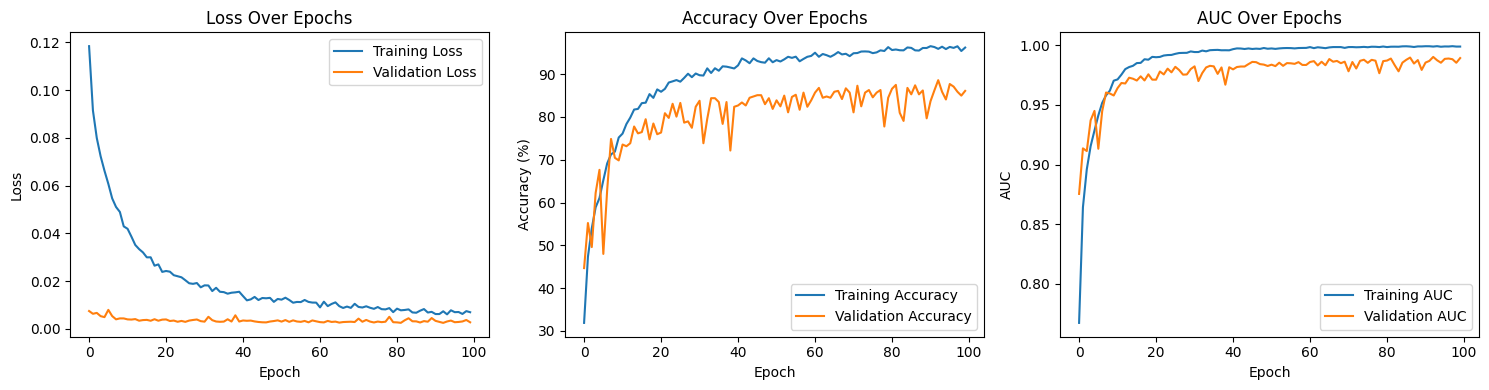

In [ ]:
import matplotlib.pyplot as plt
from torch import tensor

# Plotting the training and validation loss
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Copy auroc data to cpu
for i in range(len(train_auroc)):
  train_auroc[i] = train_auroc[i].cpu()

for i in range(len(test_auroc)):
  test_auroc[i] = test_auroc[i].cpu()

# Plotting the training and validation auroc
plt.subplot(1, 3, 3)
plt.plot(train_auroc, label='Training AUC')
plt.plot(test_auroc, label='Validation AUC')
plt.title('AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# save model architecture, weights, and biases

torch.save(model.state_dict(), '/content/drive/Shareddrives/GTZAN-ELEG405/model_weights_l2.pth')
torch.save(model, '/content/drive/Shareddrives/GTZAN-ELEG405/modell2.pth')

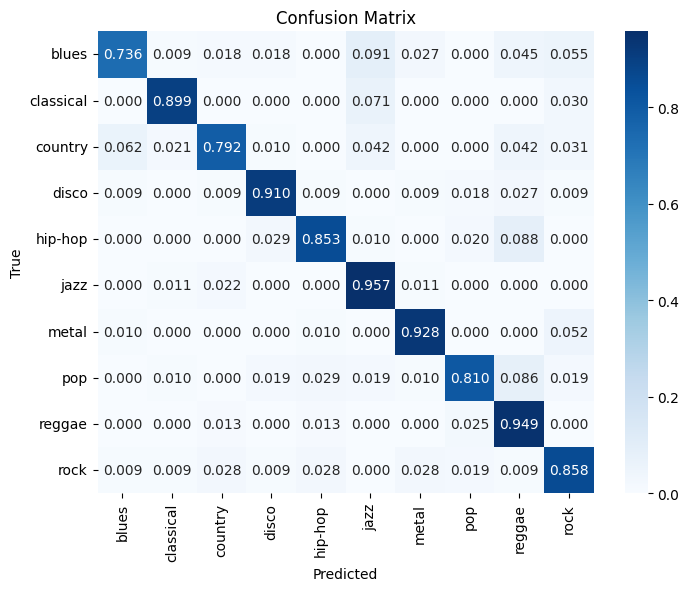

In [ ]:
# Build and display confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs.to(device)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = [
    'blues',
    'classical',
    'country',
    'disco',
    'hip-hop',
    'jazz',
    'metal',
    'pop',
    'reggae',
    'rock'
]
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt=".3f")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('output.png')

In [ ]:
# grab a few random samples to visualize some predictions
def display_sample_predictions1(model, device, test_loader, num_samples):
    model.eval()
    with torch.no_grad():
        subplot_num = 0
        for i, (data, target) in enumerate(test_loader):

            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            # if(target[i] == preds[i]):
            #     continue
            subplot_num += 1
            data[i] = data[i] / 2 + 0.5 # un-normalize
            plt.figure(figsize=(5, 20))


            plt.subplot(5, 2, subplot_num)
            plt.title(f"True: {classes[target[i].item()]}")
            # change order of data, load to cpu, convert to np, display image
            plt.imshow(data[i].permute(1, 2, 0).cpu().numpy())

            subplot_num += 1
            plt.subplot(5, 2, subplot_num)
            plt.title(f"Prediction: {classes[preds[i].item()]}")
            # change order of data, load to cpu, convert to np, display image
            plt.imshow(data[i].permute(1, 2, 0).cpu().numpy())  # Display the first image in the batch

            plt.show()

display_sample_predictions(model, device, test_loader, 5)

In [ ]:
# grab samples from incorrect classifications only
def display_sample_predictions2(model, device, test_loader, num_samples):
    model.eval()
    incorrect_predictions = []  # Store indices of incorrect predictions

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)

            # Check for incorrect predictions and store their indices
            incorrect_indices = (preds != target).nonzero()
            for idx in incorrect_indices:
                incorrect_predictions.append(idx.item())

                # If reached the required number of incorrect samples, break
                if len(incorrect_predictions) >= num_samples:
                    break

            if len(incorrect_predictions) >= num_samples:
                break  # Break out of the outer loop once enough samples are collected

    # Display images of incorrect predictions
    for idx in incorrect_predictions:
        data, target = test_loader.dataset[idx]
        data = data.to(device).unsqueeze(0)  # Add batch dimension
        target = torch.tensor([target]).to(device)  # Convert target to tensor

        output = model(data)
        pred = output.argmax(dim=1).item()

        plt.figure(figsize=(5, 5))

        plt.subplot(1, 2, 1)
        plt.title(f"True: {classes[target.item()]}")
        plt.imshow(data.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f"Prediction: {classes[pred]}")
        plt.imshow(data.squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

        plt.show()

display_sample_predictions2(model, device, test_loader, num_samples=100)

In [ ]:
# Load saved model
model.load_state_dict(torch.load('/content/drive/Shareddrives/GTZAN-ELEG405/model_weights_l2.pth'))

<All keys matched successfully>

In [ ]:
# Clear model from memory if out of memory error is thrown
import gc
del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# save the conv layer weights in this list
model_weights =[]
# save the conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")


Total convolution layers: 3
conv_layers


In [ ]:
from PIL import Image
import csv
import os
root_dir = '/content/drive/Shareddrives/GTZAN-ELEG405/cropped_imgs_jpg'

# code to
path = os.path.join(root_dir, 'blues00000.jpg')
image = Image.open(path)

In [ ]:
# process image for feature map visualization

image = original_transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 217, 335])
Image shape after: torch.Size([1, 3, 217, 335])


In [ ]:
# save convolutional layer outputs

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

3
torch.Size([1, 8, 217, 335])
torch.Size([1, 16, 217, 335])
torch.Size([1, 32, 217, 335])


In [ ]:
processed = []

# process feature maps for each conv layer
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(217, 335)
(217, 335)
(217, 335)


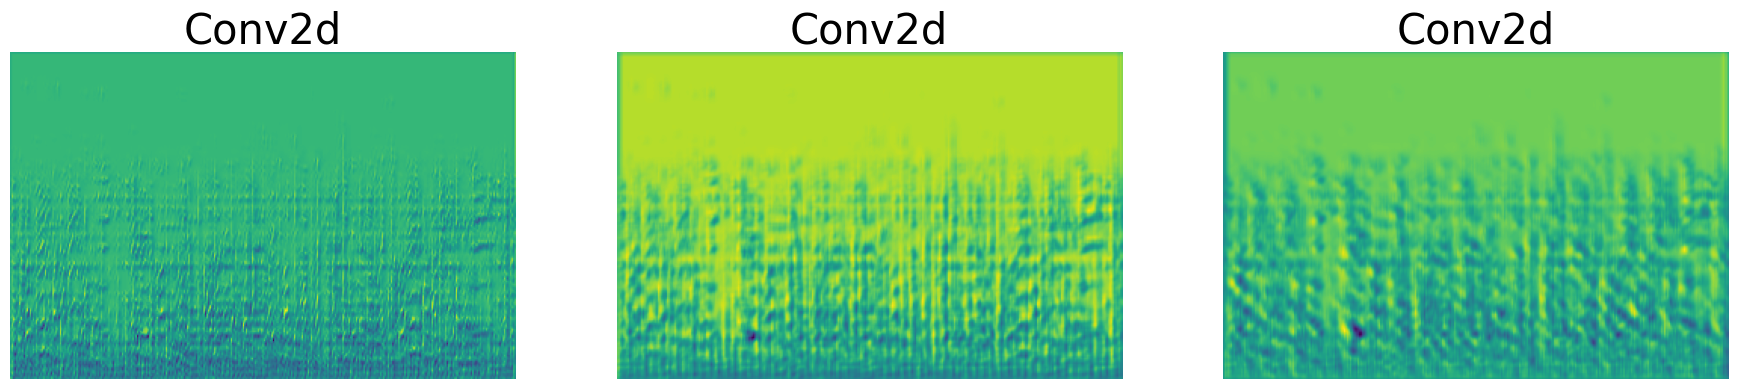

In [ ]:
import matplotlib.pyplot as plt

# display feature maps

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')